In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta

# Load the data
file_path = '/Users/haoguannan/Downloads/Portfolio_df.csv'
portfolio_df = pd.read_csv(file_path)

# Convert the 'Date' column to datetime
portfolio_df['Date'] = pd.to_datetime(portfolio_df['Date'])

# Calculate daily returns using the natural logarithm
daily_return_df = pd.DataFrame()
daily_return_df['Date'] = portfolio_df['Date']
for column in portfolio_df.columns[1:]:  # Skip the 'Date' column
    daily_return_df[column] = np.log(portfolio_df[column] / portfolio_df[column].shift(1))

# Set the first day's return to 0
daily_return_df.iloc[0, 1:] = 0

# Define the average risk-free rate (replace with actual calculated value if necessary)
risk_free_rate = 0.000056  # This is defined in another file

# Function to calculate the portfolio's Sharpe ratio
def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate):
    returns = np.sum(mean_returns * weights)  # Already annualized
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))  # Already annualized
    return std, returns

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    std, returns = portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)
    return -(returns - risk_free_rate) / std

# Calculate weights for each 4-month period
start_date = daily_return_df['Date'].min()
end_date = daily_return_df['Date'].max()
current_date = start_date
four_months = timedelta(days=4*30)

weights_list = []
dates = []

while current_date <= end_date:
    period_end_date = current_date + four_months
    period_data = daily_return_df[(daily_return_df['Date'] >= current_date) & (daily_return_df['Date'] <= period_end_date)]
    
    if len(period_data) < 2:  # Skip if not enough data
        current_date = period_end_date
        continue
    
    period_returns = period_data.iloc[:, 1:]
    mean_returns = period_returns.mean() * 252  # Annualize the mean returns
    cov_matrix = period_returns.cov() * 252  # Annualize the covariance matrix
    
    num_assets = len(mean_returns)
    init_guess = num_assets * [1. / num_assets]
    
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0.05, 1.0) for asset in range(num_assets))
    
    opt_result = minimize(neg_sharpe_ratio, init_guess,
                          args=(mean_returns, cov_matrix, risk_free_rate),
                          method='SLSQP', bounds=bounds, constraints=constraints)
    
    weights_list.append(opt_result.x)
    dates.append(current_date)
    
    current_date = period_end_date

weights_df = pd.DataFrame(weights_list, index=dates, columns=portfolio_df.columns[1:])
weights_df


/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


,BA Close,AAPL Close,MSFT Close,GOOG Close,AMZN Close
2015-01-02,0.087489,0.397181,0.050000,0.050000,0.415331
2015-05-02,0.050000,0.050000,0.050000,0.122123,0.727877
2015-08-30,0.050000,0.050000,0.366373,0.050000,0.483627
2015-12-28,0.050000,0.800000,0.050000,0.050000,0.050000
2016-04-26,0.050000,0.050000,0.257855,0.050000,0.592145
2016-08-24,0.668960,0.155551,0.075489,0.050000,0.050000
2016-12-22,0.193195,0.505468,0.074227,0.050000,0.177110
2017-04-21,0.648462,0.050000,0.201538,0.050000,0.050000
2017-08-19,0.574489,0.050000,0.222656,0.102855,0.050000
2017-12-17,0.050000,0.050000,0.050000,0.050000,0.800000


/var/folders/mf/3kxvjfxd3zxf55f4k7vp56gc0000gn/T/ipykernel_8420/2166743852.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


<Figure size 1400x800 with 0 Axes>

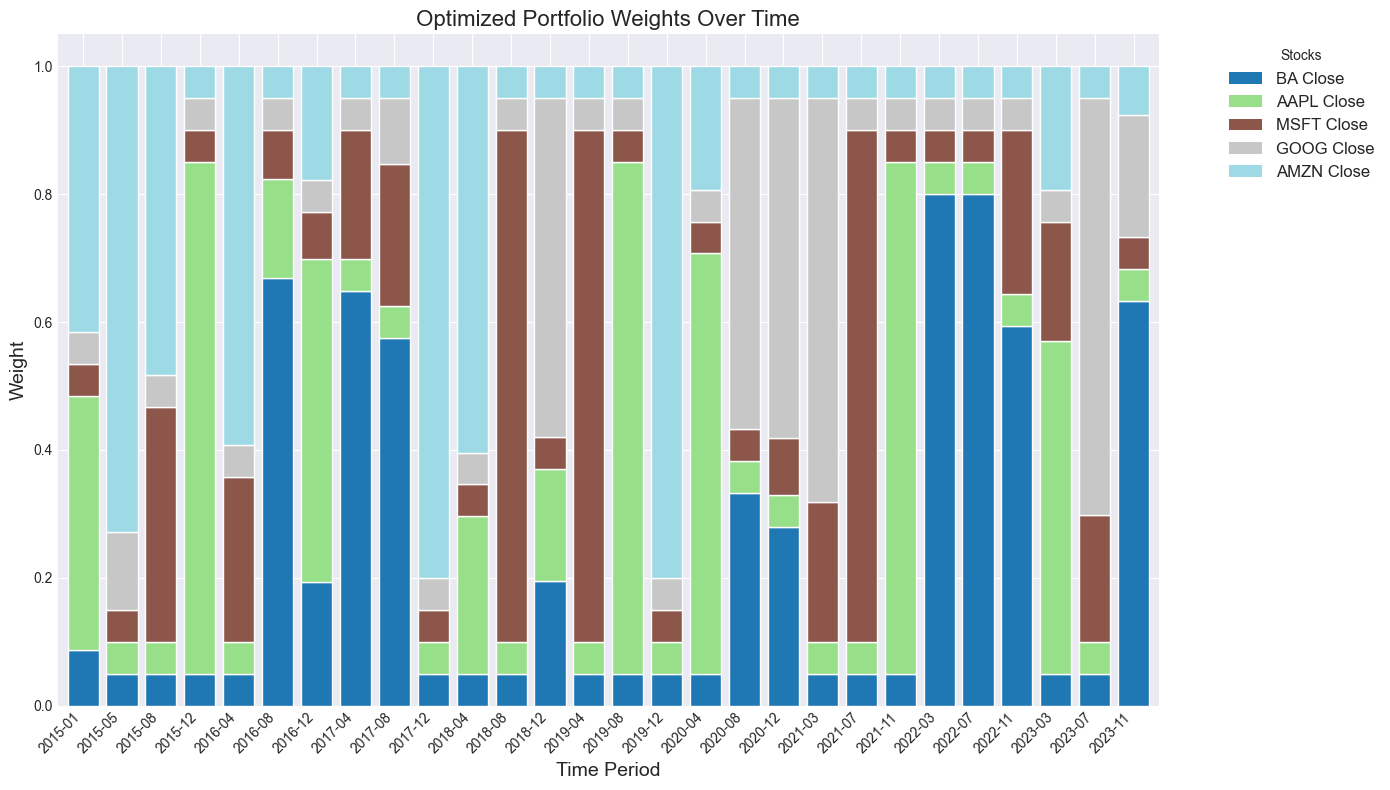

In [15]:
import matplotlib.pyplot as plt

# Plot the weight changes over time with improved aesthetics
plt.figure(figsize=(14, 8))

# Using seaborn style for better aesthetics
plt.style.use('seaborn-darkgrid')

# Plotting the stacked bar chart
ax = weights_df.plot(kind='bar', stacked=True, figsize=(14, 8), width=0.8, cmap='tab20')

# Adding titles and labels
plt.title('Optimized Portfolio Weights Over Time', fontsize=16)
plt.xlabel('Time Period', fontsize=14)
plt.ylabel('Weight', fontsize=14)

# Adjust x-axis labels for readability
ax.set_xticks(range(len(weights_df.index)))
ax.set_xticklabels([date.strftime('%Y-%m') for date in weights_df.index], rotation=45, ha='right')

# Adding legend with better placement
plt.legend(title='Stocks', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Adjusting the x-axis labels to improve readability
plt.xticks(rotation=45, ha='right')

# Making the bars larger
for bar in ax.patches:
    bar.set_edgecolor('white')

plt.tight_layout()
plt.show()


/var/folders/mf/3kxvjfxd3zxf55f4k7vp56gc0000gn/T/ipykernel_8420/3030517655.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


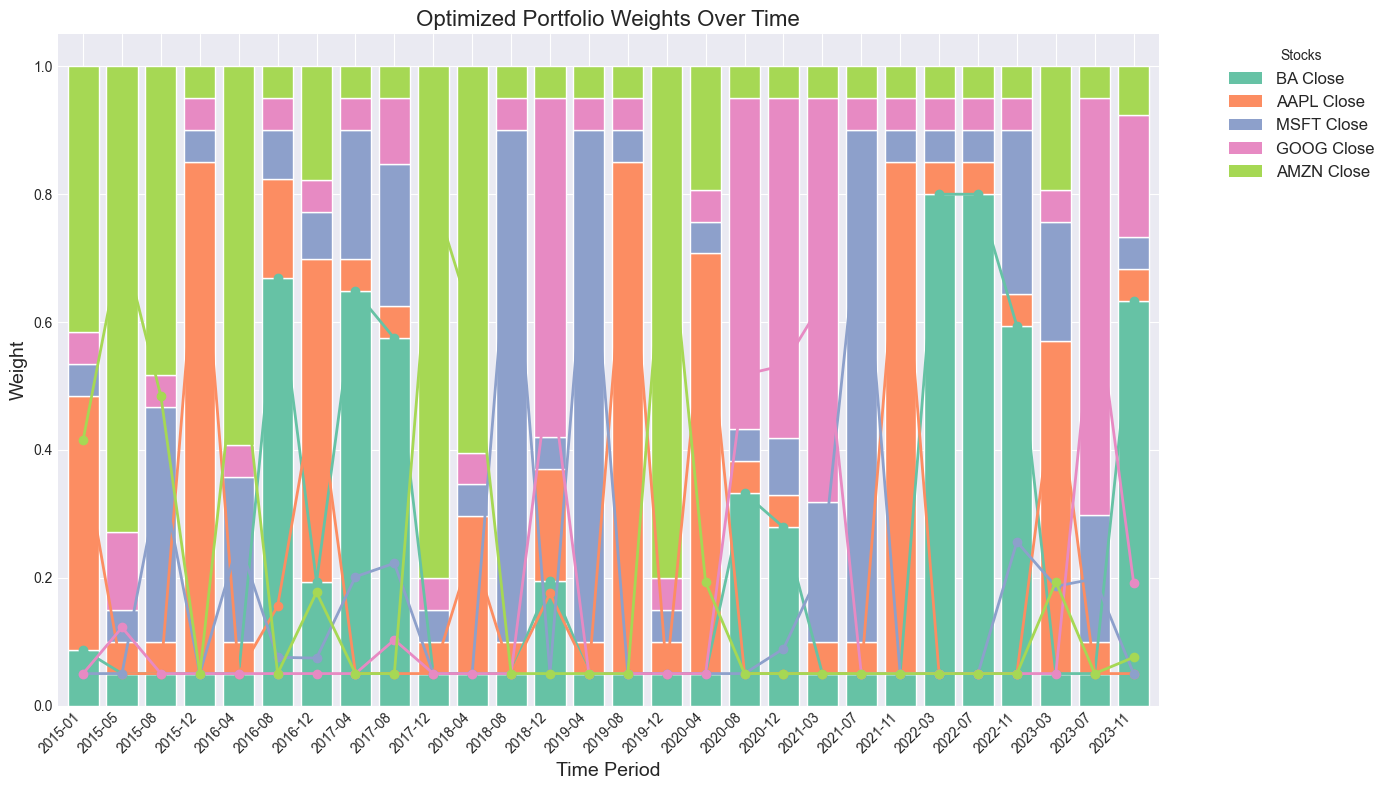

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use seaborn style for better aesthetics
plt.style.use('seaborn-darkgrid')

# Define a more attractive and academic color palette
color_palette = sns.color_palette('Set2', n_colors=len(weights_df.columns))

# Plot the weight changes over time with improved aesthetics
fig, ax = plt.subplots(figsize=(14, 8))

# Plot the stacked bar chart
weights_df.plot(kind='bar', stacked=True, ax=ax, width=0.8, color=color_palette)

# Add titles and labels
ax.set_title('Optimized Portfolio Weights Over Time', fontsize=16)
ax.set_xlabel('Time Period', fontsize=14)
ax.set_ylabel('Weight', fontsize=14)

# Adjust x-axis labels for readability
ax.set_xticks(range(len(weights_df.index)))
ax.set_xticklabels([date.strftime('%Y-%m') for date in weights_df.index], rotation=45, ha='right')

# Add legend with better placement
ax.legend(title='Stocks', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Plot the trend lines on top of the bars
for i, column in enumerate(weights_df.columns):
    x = range(len(weights_df.index))
    y = weights_df[column].values
    ax.plot(x, y, marker='o', color=color_palette[i], label=f'{column} Trend', linewidth=2, markersize=6)

# Make the bars larger
for bar in ax.patches:
    bar.set_edgecolor('white')

plt.tight_layout()
plt.show()



In [3]:
# Calculate the portfolio expected return and standard deviation for each 4-month period
expected_returns = []
expected_std_devs = []

for date in weights_df.index:
    period_data = daily_return_df[(daily_return_df['Date'] >= date) & (daily_return_df['Date'] < date + four_months)]
    period_returns = period_data.iloc[:, 1:]
    mean_returns = period_returns.mean() * 252  # Annualize the mean returns
    cov_matrix = period_returns.cov() * 252  # Annualize the covariance matrix
    
    weights = weights_df.loc[date].values
    portfolio_std_dev, portfolio_return = portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)
    
    expected_returns.append(portfolio_return)
    expected_std_devs.append(portfolio_std_dev)

# Create a DataFrame for expected returns and standard deviations
performance_df = pd.DataFrame({
    'Date': weights_df.index,
    'Expected Return': expected_returns,
    'Expected Std Dev': expected_std_devs
})

print(performance_df)


         Date  Expected Return  Expected Std Dev
0  2015-01-02         0.642775          0.229215
1  2015-05-02         0.464849          0.271374
2  2015-08-30         0.672643          0.241243
3  2015-12-28        -0.090734          0.259532
4  2016-04-26         0.464415          0.181882
5  2016-08-24         0.402123          0.132884
6  2016-12-22         0.502695          0.103896
7  2017-04-21         0.664222          0.157501
8  2017-08-19         0.615301          0.111742
9  2017-12-17         0.513851          0.282945
10 2018-04-16         0.703631          0.174750
11 2018-08-14        -0.056574          0.298052
12 2018-12-12         0.425696          0.251640
13 2019-04-11         0.351482          0.203053
14 2019-08-09         0.734131          0.204045
15 2019-12-07         0.003398          0.428992
16 2020-04-05         1.575579          0.324687
17 2020-08-03         0.578628          0.297327
18 2020-12-01         0.424790          0.241880
19 2021-03-31       

In [5]:
# Generate the daily return and daily rolling std deviation CSV file from 2015-2023
rolling_window = 30  # Set the rolling window size

portfolio_daily_returns = []
portfolio_daily_std_devs = []

for i in range(len(daily_return_df)):
    current_date = daily_return_df['Date'].iloc[i]
    weights = weights_df.loc[weights_df.index <= current_date].iloc[-1].values  # Use the most recent weights
    
    daily_return = np.dot(daily_return_df.iloc[i, 1:], weights)
    portfolio_daily_returns.append(daily_return)
    
    if i >= rolling_window:
        rolling_std_dev = np.std(portfolio_daily_returns[-rolling_window:])
    else:
        rolling_std_dev = np.std(portfolio_daily_returns)
    
    portfolio_daily_std_devs.append(rolling_std_dev)

daily_metrics_df = pd.DataFrame({
    'Date': daily_return_df['Date'],
    'Portfolio Daily Return': portfolio_daily_returns,
    'Portfolio Rolling Std Dev': portfolio_daily_std_devs
})

output_file_path = '/Users/haoguannan/Downloads/portfolio_daily_metrics_1.csv'
daily_metrics_df.to_csv(output_file_path, index=False)

print(f"Daily metrics saved to {output_file_path}")


Daily metrics saved to /Users/haoguannan/Downloads/portfolio_daily_metrics_1.csv


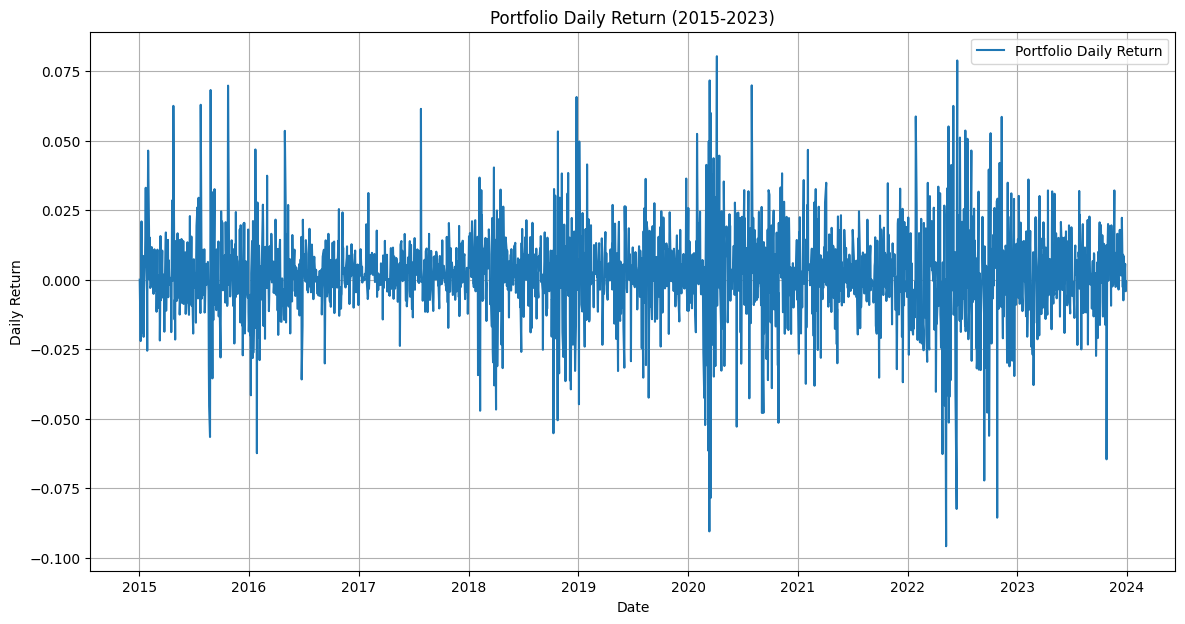

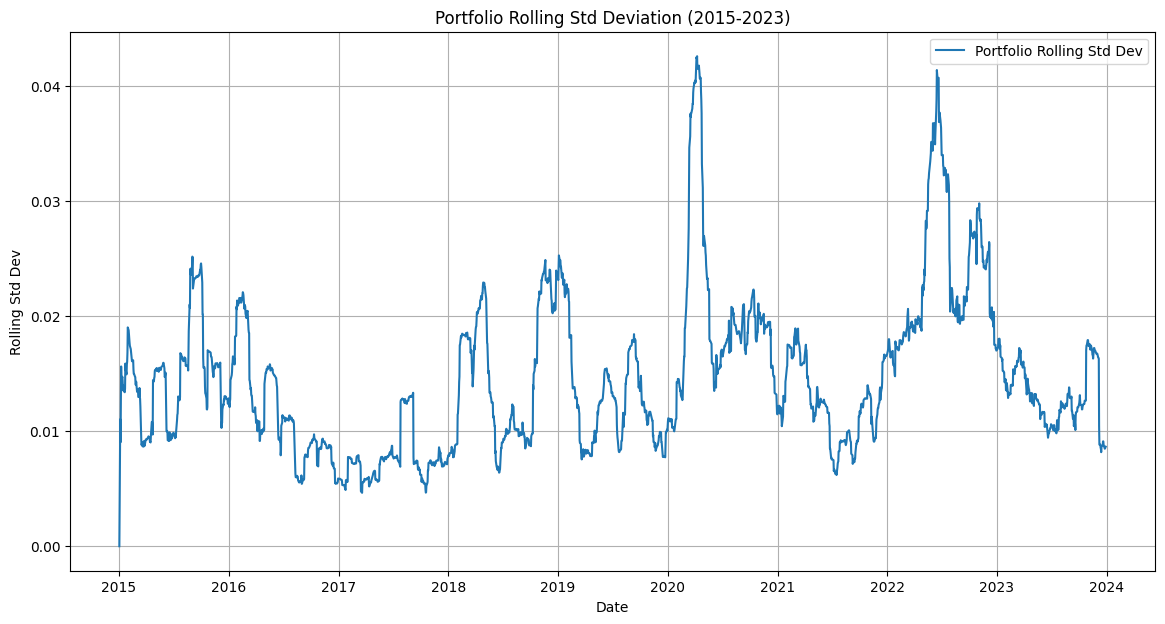

In [6]:
# Plot the daily return and daily rolling std deviation from 2015-2023
plt.figure(figsize=(14, 7))
plt.plot(daily_metrics_df['Date'], daily_metrics_df['Portfolio Daily Return'], label='Portfolio Daily Return')
plt.title('Portfolio Daily Return (2015-2023)')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(daily_metrics_df['Date'], daily_metrics_df['Portfolio Rolling Std Dev'], label='Portfolio Rolling Std Dev')
plt.title('Portfolio Rolling Std Deviation (2015-2023)')
plt.xlabel('Date')
plt.ylabel('Rolling Std Dev')
plt.legend()
plt.grid(True)
plt.show()


<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

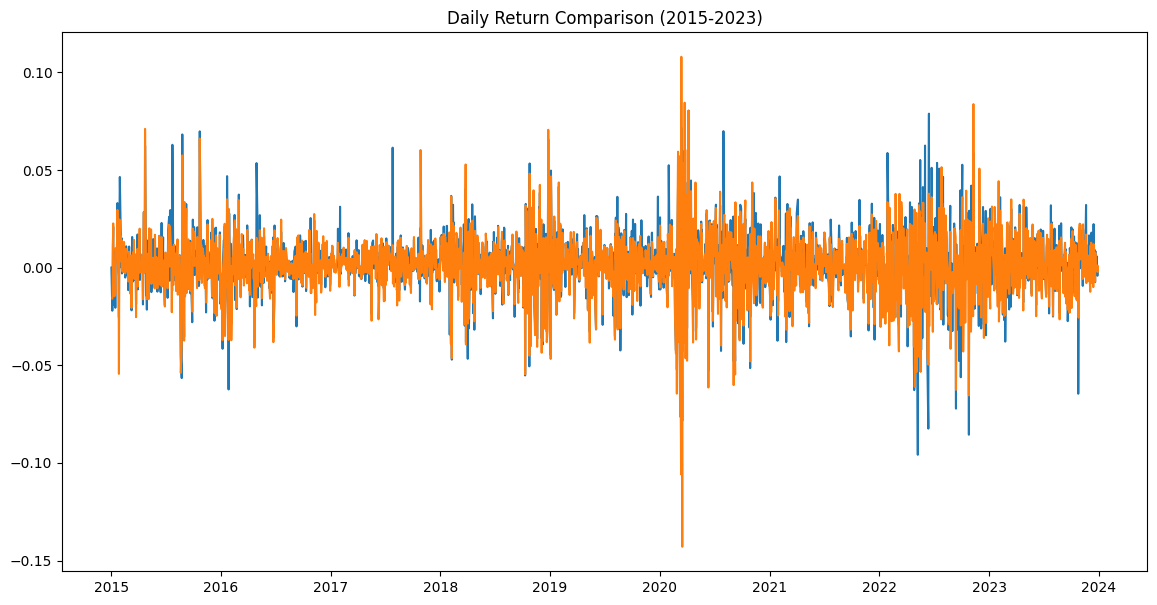

In [7]:
# Previous optimal weights
previous_opt_weights = np.array([0.1, 0.179278, 0.431625, 0.1, 0.189098])

# Calculate previous portfolio daily returns
previous_portfolio_daily_returns = daily_return_df.iloc[1:, 1:].dot(previous_opt_weights)

# Calculate previous portfolio rolling standard deviation
previous_portfolio_daily_std_devs = previous_portfolio_daily_returns.rolling(window=rolling_window).std()

# Plot daily return comparison
plt.figure(figsize=(14, 7))
plt.plot(daily_metrics_df['Date'], daily_metrics_df['Portfolio Daily Return'], label='New Portfolio Daily Return')
plt.plot(daily_return_df['Date'][1:], previous_portfolio_daily_returns, label='Previous Portfolio Daily Return')
plt.title('Daily Return Comparison (2015-2023)')
plt.xlabel


/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


            BA Close  AAPL Close  MSFT Close  GOOG Close  AMZN Close
2015-01-02  0.087489    0.397181    0.050000    0.050000    0.415331
2015-05-02  0.050000    0.050000    0.050000    0.122123    0.727877
2015-08-30  0.050000    0.050000    0.366373    0.050000    0.483627
2015-12-28  0.050000    0.800000    0.050000    0.050000    0.050000
2016-04-26  0.050000    0.050000    0.257855    0.050000    0.592145
2016-08-24  0.668960    0.155551    0.075489    0.050000    0.050000
2016-12-22  0.193195    0.505468    0.074227    0.050000    0.177110
2017-04-21  0.648462    0.050000    0.201538    0.050000    0.050000
2017-08-19  0.574489    0.050000    0.222656    0.102855    0.050000
2017-12-17  0.050000    0.050000    0.050000    0.050000    0.800000
2018-04-16  0.050000    0.245826    0.050000    0.050000    0.604174
2018-08-14  0.050000    0.050000    0.800000    0.050000    0.050000
2018-12-12  0.195252    0.175464    0.050000    0.529284    0.050000
2019-04-11  0.050000    0.050000  

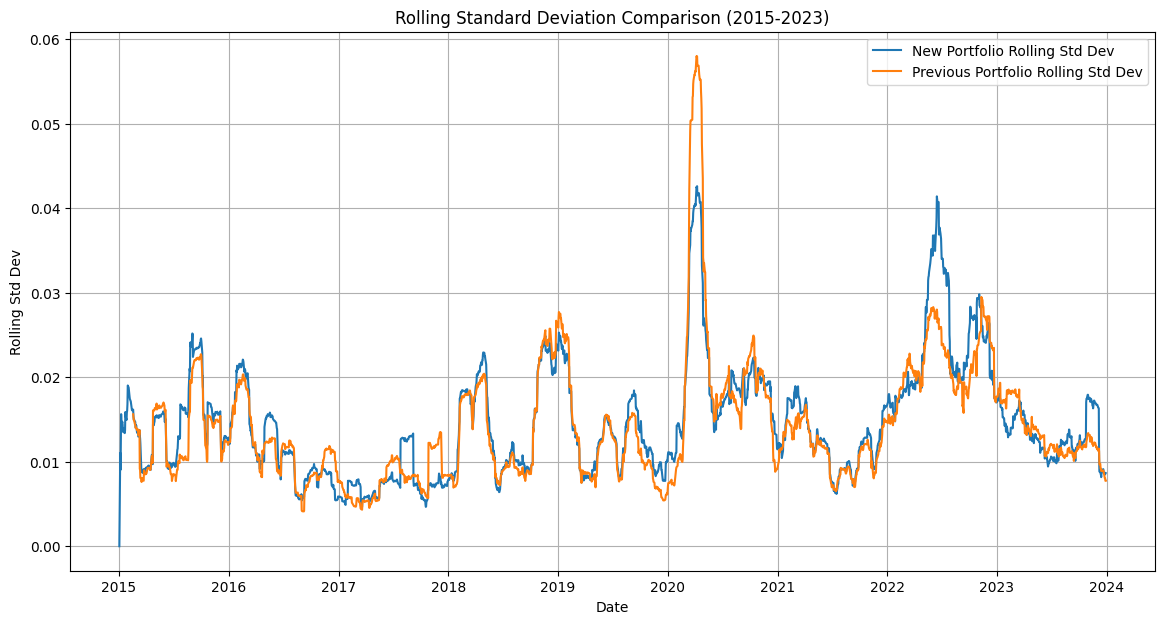

In [10]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta

# Load the data
file_path = '/Users/haoguannan/Downloads/Portfolio_df.csv'
portfolio_df = pd.read_csv(file_path)

# Convert the 'Date' column to datetime
portfolio_df['Date'] = pd.to_datetime(portfolio_df['Date'])

# Calculate daily returns using the natural logarithm
daily_return_df = pd.DataFrame()
daily_return_df['Date'] = portfolio_df['Date']
for column in portfolio_df.columns[1:]:  # Skip the 'Date' column
    daily_return_df[column] = np.log(portfolio_df[column] / portfolio_df[column].shift(1))

# Set the first day's return to 0
daily_return_df.iloc[0, 1:] = 0

# Define the average risk-free rate (replace with actual calculated value if necessary)
risk_free_rate = 0.000056  # This is defined in another file

# Function to calculate the portfolio's Sharpe ratio
def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate):
    returns = np.sum(mean_returns * weights)  # Already annualized
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))  # Already annualized
    return std, returns

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    std, returns = portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)
    return -(returns - risk_free_rate) / std

# Calculate weights for each 4-month period
start_date = daily_return_df['Date'].min()
end_date = daily_return_df['Date'].max()
current_date = start_date
four_months = timedelta(days=4*30)

weights_list = []
dates = []

while current_date <= end_date:
    period_end_date = current_date + four_months
    period_data = daily_return_df[(daily_return_df['Date'] >= current_date) & (daily_return_df['Date'] <= period_end_date)]
    
    if len(period_data) < 2:  # Skip if not enough data
        current_date = period_end_date
        continue
    
    period_returns = period_data.iloc[:, 1:]
    mean_returns = period_returns.mean() * 252  # Annualize the mean returns
    cov_matrix = period_returns.cov() * 252  # Annualize the covariance matrix
    
    num_assets = len(mean_returns)
    init_guess = num_assets * [1. / num_assets]
    
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0.05, 1.0) for asset in range(num_assets))
    
    opt_result = minimize(neg_sharpe_ratio, init_guess,
                          args=(mean_returns, cov_matrix, risk_free_rate),
                          method='SLSQP', bounds=bounds, constraints=constraints)
    
    weights_list.append(opt_result.x)
    dates.append(current_date)
    
    current_date = period_end_date

weights_df = pd.DataFrame(weights_list, index=dates, columns=portfolio_df.columns[1:])
print(weights_df)

# Generate the daily return and daily rolling std deviation CSV file from 2015-2023
rolling_window = 30  # Set the rolling window size

portfolio_daily_returns = []
portfolio_daily_std_devs = []

for i in range(len(daily_return_df)):
    current_date = daily_return_df['Date'].iloc[i]
    weights = weights_df.loc[weights_df.index <= current_date].iloc[-1].values  # Use the most recent weights
    
    daily_return = np.dot(daily_return_df.iloc[i, 1:], weights)
    portfolio_daily_returns.append(daily_return)
    
    if i >= rolling_window:
        rolling_std_dev = np.std(portfolio_daily_returns[-rolling_window:])
    else:
        rolling_std_dev = np.std(portfolio_daily_returns)
    
    portfolio_daily_std_devs.append(rolling_std_dev)

daily_metrics_df = pd.DataFrame({
    'Date': daily_return_df['Date'],
    'Portfolio Daily Return': portfolio_daily_returns,
    'Portfolio Rolling Std Dev': portfolio_daily_std_devs
})

output_file_path = '/Users/haoguannan/Downloads/portfolio_daily_metrics.csv'
daily_metrics_df.to_csv(output_file_path, index=False)

print(f"Daily metrics saved to {output_file_path}")

# Previous optimal weights
previous_opt_weights = np.array([0.1, 0.179278, 0.431625, 0.1, 0.189098])

# Calculate previous portfolio daily returns
previous_portfolio_daily_returns = daily_return_df.iloc[1:, 1:].dot(previous_opt_weights)

# Calculate previous portfolio rolling standard deviation
previous_portfolio_daily_std_devs = previous_portfolio_daily_returns.rolling(window=rolling_window).std()

# Plot rolling standard deviation comparison
plt.figure(figsize=(14, 7))
plt.plot(daily_metrics_df['Date'], daily_metrics_df['Portfolio Rolling Std Dev'], label='New Portfolio Rolling Std Dev')
plt.plot(daily_return_df['Date'][1:], previous_portfolio_daily_std_devs, label='Previous Portfolio Rolling Std Dev')
plt.title('Rolling Standard Deviation Comparison (2015-2023)')
plt.xlabel('Date')
plt.ylabel('Rolling Std Dev')
plt.legend()
plt.grid(True)
plt.show()
